Notebook with toy example to test/demonstrate bayesian hierarchical clustering

In [15]:
%%capture
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df

NUM_SAMPLE = 5
NUM_BIN = 12
CHR_NAMES = ["1","2"]

#max_cn = cn_mat.max()
max_cn = 7
print(f"max_cn: {max_cn}")

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1., seed=1, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=3., seed=3, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids


df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]


cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

display(cn_data.head())

tlinkage, root = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

print("-------final -----------------")
print(tlinkage)
print(root)

array([[0.        , 1.        , 0.14142136, 2.        ],
       [2.        , 3.        , 0.14142136, 2.        ],
       [4.        , 5.        , 1.41421356, 4.        ]])

,i,j,r_merge,i_count,j_count,merge_count
0,0,4,1.00465,1,1,2
1,1,2,1.00144,1,1,2
2,2,6,1.00063,1,1,2
3,5,6,1.00039,1,1,2
4,3,4,1.00037,1,1,2
5,3,4,-0.0656566,2,2,4
6,0,3,25.527,2,4,6
7,1,2,-0.118599,2,2,4
8,0,1,1.70841,6,4,10


ValueError: Linkage 'Z' contains negative distances.

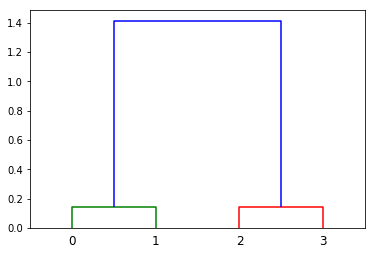

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage

data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1]]

Z = linkage(data)

display(Z)
display(tlinkage)
dendrogram(Z) 
dendrogram(tlinkage[["i","j","r_merge","merge_count"]].to_numpy().astype("float"))